In [234]:
# Building a basic selector ML algorithm for picking simulation strategy with inferQ data

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [236]:
import numpy as np
import pandas as pd

df = pd.read_csv("circuits_data100000.csv")

df = df.replace(
    ["none", "None", "NONE", "", "null", "NULL"],
    np.nan
)

C:\Users\aadik\AppData\Local\Temp\ipykernel_5332\4114600267.py:4: DtypeWarning: Columns (3,5,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("circuits_data100000.csv")


In [237]:
df.dtypes[df.dtypes == "object"]

PartitionKey                        object
RowKey                              object
automatic_gate_counts               object
automatic_method                    object
blob_url                            object
connected_components                object
core_number                         object
density_matrix_gate_counts          object
extended_stabilizer_gate_counts     object
gate_counts                         object
matrix_product_state_gate_counts    object
name                                object
pagerank                            object
serialization_method                object
simulation_method                   object
stabilizer_gate_counts              object
statevector_gate_counts             object
statevector_saved_gate_counts       object
unitary_gate_counts                 object
dtype: object

In [238]:
FEATURES = [
    # Circuit size & structure
    "num_qubits",
    # "circuit_qubits",
    "width",
    "depth",
    # "circuit_depth",
    "circuit_size",
    # "gate_counts",
    "pauli_gate_count",
    "two_qubit_gate_count",
    "two_qubit_gate_percentage",
    # "transpiled_depth",
    # "transpiled_size",
    # "transpiled_qubits",

    # Graph features
    "igdepth",
    "node_count",
    "edge_count",
    "average_degree",
    "max_degree",
    "average_shortest_path_length",
    "average_clustering_coefficient",
    "diameter",
    "radius",
    # "pagerank",
    # # "core_number",
    # # "connected_components",
    "central_point_of_dominance",
    "density_score",
    "std_dev_adjacency_matrix",
    "min_cut_upper",

    # Sparsity / locality
    # "sparsity",
    "locality_ratio",
    "idling_score",
    # "statevector_entropy",
    "statevector_saved_entropy",
    "statevector_saved_sparsity",
]


In [239]:
df = df.replace(
    ["none", "None", "NONE", "", "null", "NULL"],
    np.nan
)

missing = (
    df[FEATURES]
    .isna()
    .sum()
    .to_frame("missing_count")
)

missing["missing_fraction"] = missing["missing_count"] / len(df)
missing = missing.sort_values("missing_count", ascending=False)

print(missing)


                                missing_count  missing_fraction
statevector_saved_entropy               51443           0.51443
statevector_saved_sparsity              51443           0.51443
radius                                   2563           0.02563
diameter                                 2563           0.02563
num_qubits                                  0           0.00000
width                                       0           0.00000
depth                                       0           0.00000
circuit_size                                0           0.00000
igdepth                                     0           0.00000
two_qubit_gate_percentage                   0           0.00000
two_qubit_gate_count                        0           0.00000
pauli_gate_count                            0           0.00000
max_degree                                  0           0.00000
average_degree                              0           0.00000
node_count                              

In [240]:
before = len(df)
df_dropped = df.dropna(subset=FEATURES)
after = len(df_dropped)

print(f"Rows kept: {after/before:.2%}")

Rows kept: 46.08%


In [241]:
METHODS = [
    # "statevector_saved",
    "statevector",
    "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    "unitary",
    "automatic"
]
alpha = 1e-9

In [242]:
def best_method(row):
    costs = {}
    for m in METHODS:
        t = row.get(f"{m}_execution_time")
        mem = row.get(f"{m}_memory_usage")
        if pd.isna(t) or pd.isna(mem):
            continue
        costs[m] = t
    return min(costs, key=costs.get) if costs else np.nan

df_dropped["best_method"] = df_dropped.apply(best_method, axis=1)
df_clean = df_dropped.dropna(subset=["best_method"])

C:\Users\aadik\AppData\Local\Temp\ipykernel_5332\3841572760.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped["best_method"] = df_dropped.apply(best_method, axis=1)


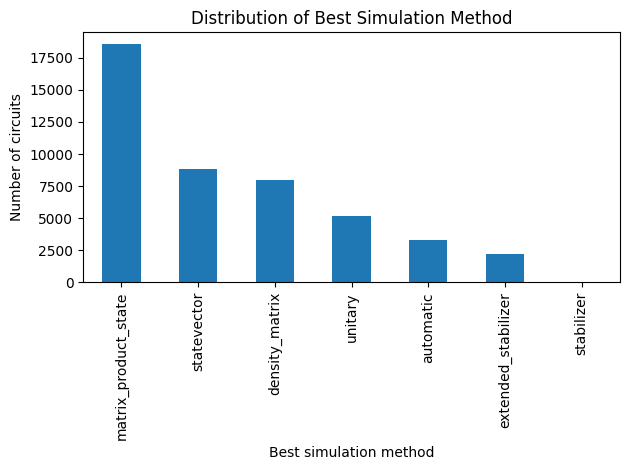

In [243]:
import matplotlib.pyplot as plt

df_clean["best_method"].value_counts().plot(kind="bar")

plt.xlabel("Best simulation method")
plt.ylabel("Number of circuits")
plt.title("Distribution of Best Simulation Method")
plt.tight_layout()
plt.show()


In [244]:
total = len(df_clean)
print(df_clean["best_method"].value_counts())
print(len(df_clean))
print(df_clean["best_method"].value_counts()/total)

best_method
matrix_product_state    18558
statevector              8838
density_matrix           7953
unitary                  5135
automatic                3338
extended_stabilizer      2220
stabilizer                 42
Name: count, dtype: int64
46084
best_method
matrix_product_state    0.402699
statevector             0.191780
density_matrix          0.172576
unitary                 0.111427
automatic               0.072433
extended_stabilizer     0.048173
stabilizer              0.000911
Name: count, dtype: float64


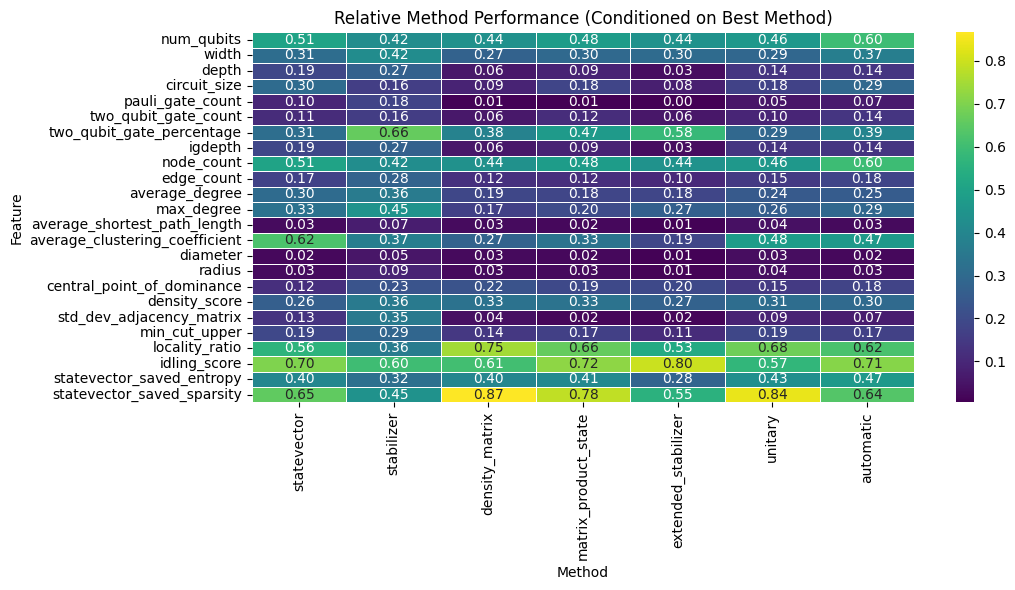

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

METHODS = [
    "statevector",
    "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    "unitary",
    "automatic",
]

matrix = pd.DataFrame(index=FEATURES, columns=METHODS, dtype=float)

for method in METHODS:
    subset = df_clean[df_clean["best_method"] == method]
    for feature in FEATURES:
        mx, mi = subset[feature].max(),subset[feature].min()
        if mx - mi > 0:
            matrix.loc[feature, method] = (subset[feature].mean()-mi)/(mx-mi)
        else:
            matrix.loc[feature, method] = 0.0

# --- Min–max normalize per feature (row-wise) ---
matrix_norm = matrix.copy()

# --- Plot heatmap ---
plt.figure(figsize=(11, 6))
sns.heatmap(
    matrix_norm,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Relative Method Performance (Conditioned on Best Method)")
plt.xlabel("Method")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


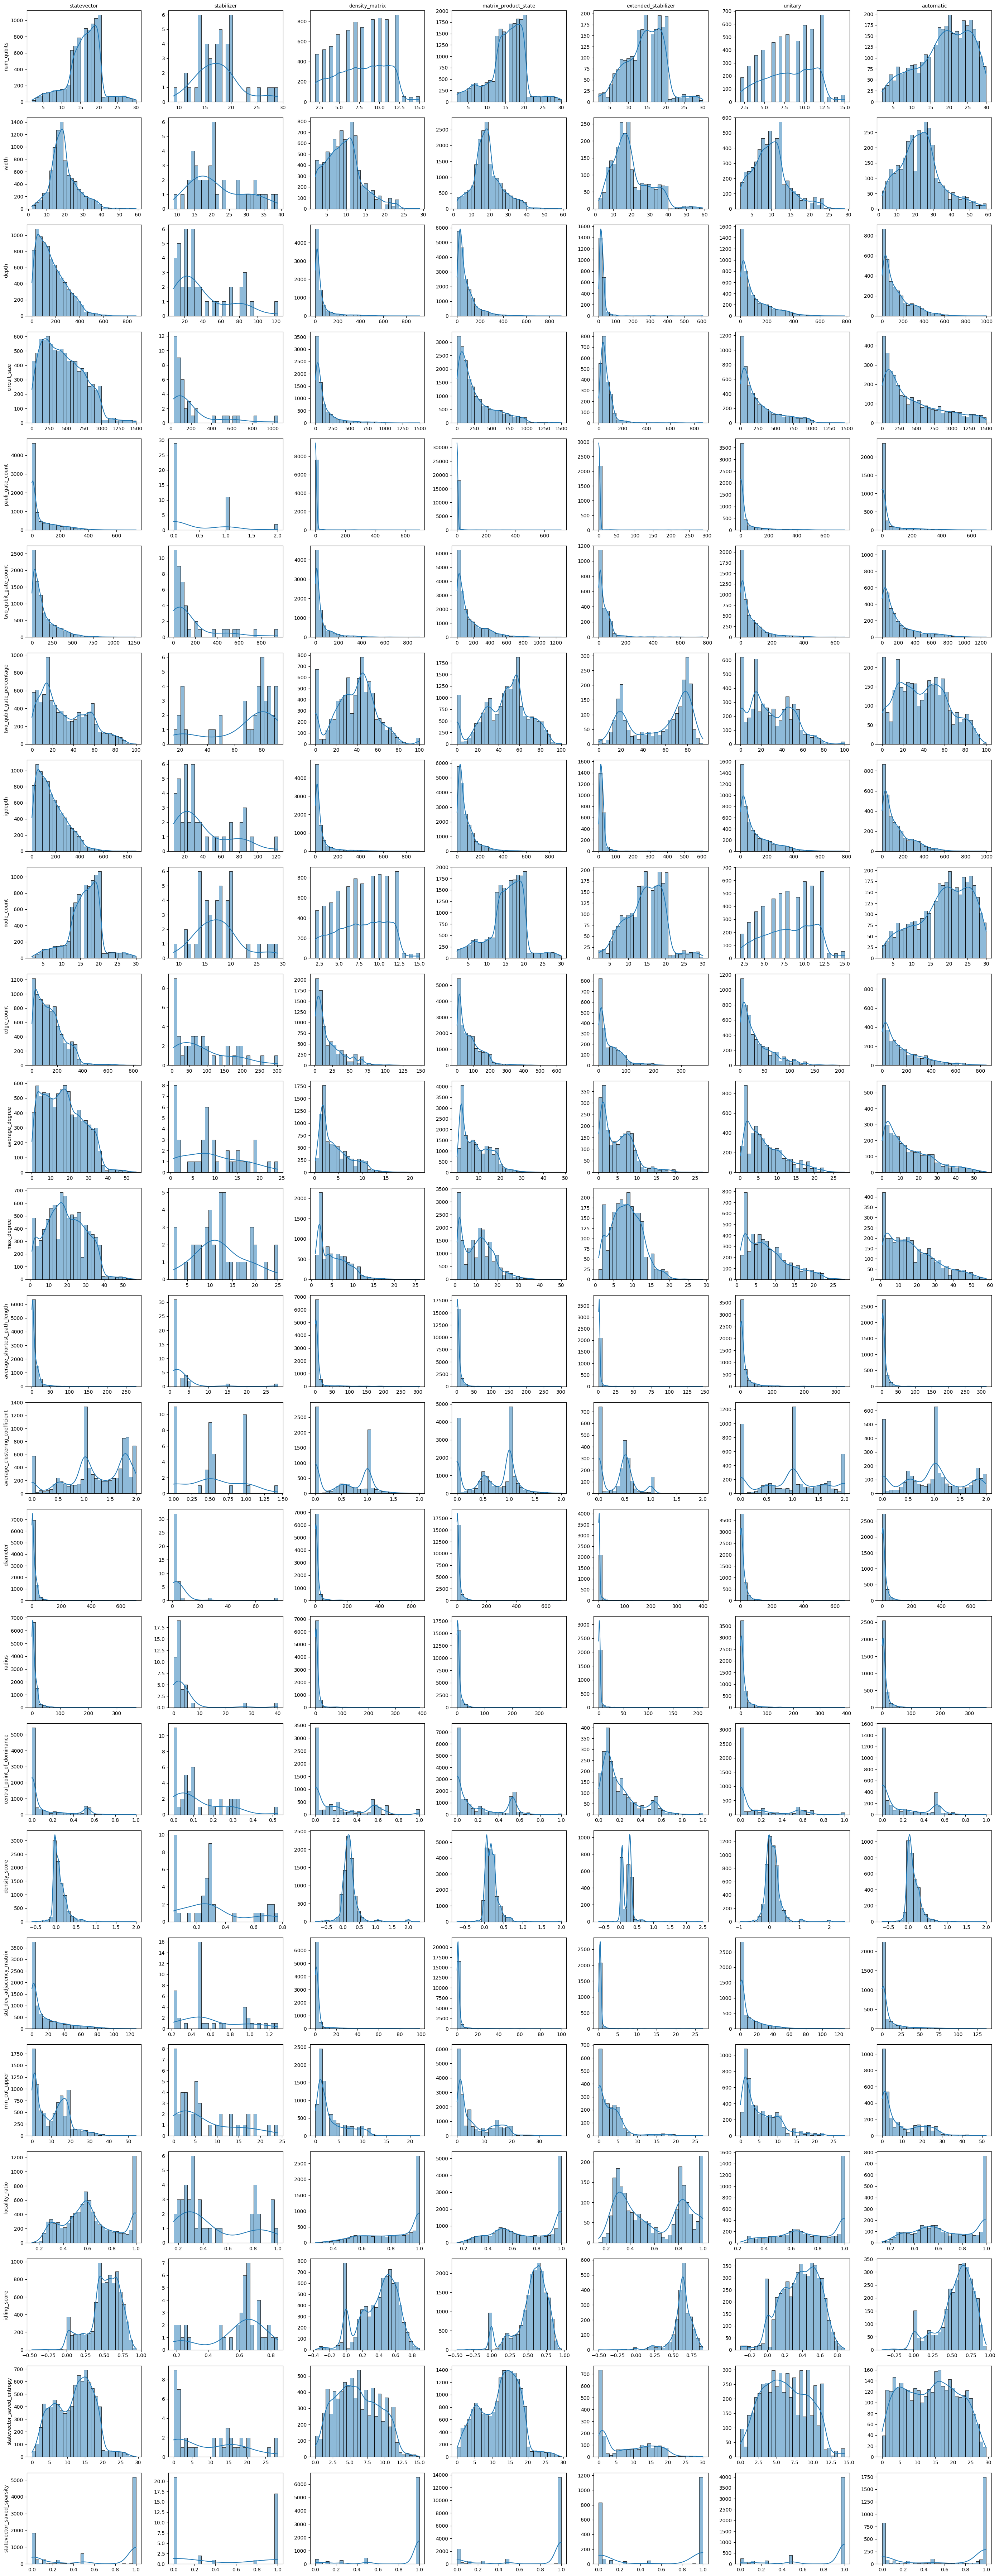

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

METHODS = [
    "statevector",
    "stabilizer",
    "density_matrix",
    "matrix_product_state",
    "extended_stabilizer",
    "unitary",
    "automatic",
]

n_rows = len(FEATURES)
n_cols = len(METHODS)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=False,
    sharey=False
)

for i, feature in enumerate(FEATURES):
    for j, method in enumerate(METHODS):
        ax = axes[i, j]

        subset = df_clean[df_clean["best_method"] == method]
        col = feature

        if col in subset.columns and not subset.empty:
            data = subset[col].dropna()

            if len(data) > 0:
                sns.histplot(
                    data,
                    bins=30,
                    kde=True,
                    ax=ax
                )

        if i == 0:
            ax.set_title(method, fontsize=10)

        if j == 0:
            ax.set_ylabel(feature, fontsize=10)
        else:
            ax.set_ylabel("")

        ax.set_xlabel("")

plt.tight_layout()
plt.show()


In [247]:
X = df_clean[FEATURES].select_dtypes(include=[np.number])
y = df_clean["best_method"]

# PCA 

# Random Forest 

                      precision    recall  f1-score   support

         statevector       0.52      0.25      0.34       667
          stabilizer       0.48      0.92      0.63      1591
      density_matrix       0.54      0.66      0.60       444
matrix_product_state       0.74      0.73      0.73      3712
 extended_stabilizer       0.00      0.00      0.00         8
             unitary       0.86      0.47      0.61      1768
           automatic       0.63      0.39      0.48      1027

            accuracy                           0.64      9217
           macro avg       0.54      0.49      0.48      9217
        weighted avg       0.68      0.64      0.63      9217



c:\Users\aadik\InferQ\analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aadik\InferQ\analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\aadik\InferQ\analysis\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

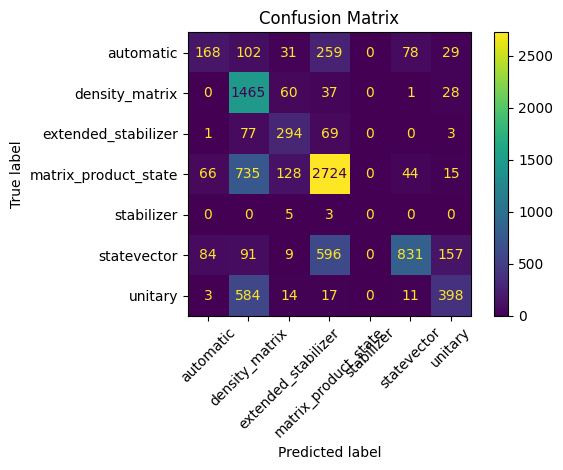

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

TARGET = "best_method"
RANDOM_STATE = 42

X = df_clean[FEATURES].select_dtypes(include=[np.number])
y = df_clean[TARGET]

y_original = df_clean[TARGET]


X_train, X_test, y_train, y_test, y_orig_train, y_orig_test = train_test_split(
    X, y, y_original,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)


from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    min_samples_leaf=10,
    n_jobs=-1,
    random_state=RANDOM_STATE
)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(
    y_test, y_pred,
    target_names = METHODS
))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    xticks_rotation=45
)

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
